<a name='0'></a>
# Random Forests - Classification

* Random Forests are supervised ML models for classification and regression.
* They average predictions from multiple randomized decision trees.
* They reduce overfitting compared to single decision trees.
* Random Forests are a type of ensemble model.
* They can measure feature importance for model interpretation.


### Contents

* [1 - Imports](#1)
* [2 - Loading the data](#2)
* [3 - Exploratory Analysis](#3)
* [4 - Preprocessing the data](#4)
* [5 - Training Random Forests Classifier](#5)
* [6 - Evaluating Random Forests Classifier](#6)
* [7 - Improving Random Forests Classifier](#7)
* [8 - Evaluating the Improved Model on the Test Set ](#8)
* [9 - Feature Importance](#9)

<a name='1'></a>
## 1 - Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a name='2'></a>

## 2 - Loading the data

---

* Dataset from **Australian New South Wales Electricity Market**.
* Prices change every **five minutes** due to demand and supply.
* Includes **45,312 instances** (7 May 1996 → 5 Dec 1998).
* Each instance = **30 minutes of data** (48 instances/day).
* Purpose: Build a **Random Forest classifier** to predict price changes.
* Source: [OpenML electricity dataset](https://www.openml.org/d/151)

---

Here are the information about the features:

* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

In [2]:
# hiding warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the function to load datasets from OpenML
from sklearn.datasets import fetch_openml

# Loading the 'electricity' dataset (version 1) from OpenML
elec_data = fetch_openml(name='electricity', version=1)

In [4]:
# Checking the type of the loaded dataset
type(elec_data)

sklearn.utils._bunch.Bunch

In [5]:
# Getting the shape (rows, columns) of the dataset features
elec_data.data.shape

(45312, 8)

In [6]:
# Listing the feature names (column names) in the dataset
elec_data.feature_names

['date',
 'day',
 'period',
 'nswprice',
 'nswdemand',
 'vicprice',
 'vicdemand',
 'transfer']

In [7]:
# Listing the names of the target classes in the dataset
elec_data.target_names

['class']

In [8]:
# Creating a DataFrame from the loaded electricity dataset
elec_df = elec_data.frame

In [9]:
# Checking the type of the created DataFrame
type(elec_df)

pandas.core.frame.DataFrame

<a name='3'></a>
## 3 - Exploratory Data Analysis

In [10]:
# Splitting the dataset into training (75%) and testing (25%) sets

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(elec_df, test_size=0.25, random_state=20)

print('The size of training data is: {} \nThe size of testing data is: {}'.format(len(train_data), len(test_data)))

The size of training data is: 33984 
The size of testing data is: 11328


In [11]:
# Separating features (X_train) and target labels (y_train) for training data

X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

In [12]:
train_data.head(10)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
27325,0.469846,4,0.276596,0.164705,0.519637,0.011417,0.657949,0.265789,DOWN
28731,0.474227,5,0.574468,0.024919,0.191907,0.001656,0.090886,0.819737,DOWN
8450,0.023141,3,0.042553,0.065270,0.250074,0.003467,0.422915,0.414912,DOWN
36659,0.889385,2,0.744681,0.148193,0.670039,0.009981,0.533402,0.563596,UP
781,0.000708,4,0.276596,0.124204,0.475454,0.003467,0.422915,0.414912,UP
13013,0.428963,7,0.106383,0.055242,0.084647,0.003467,0.422915,0.414912,DOWN
3330,0.009203,1,0.382979,0.045635,0.741892,0.003467,0.422915,0.414912,DOWN
18851,0.446662,2,0.744681,0.183409,0.785034,0.012154,0.757639,0.517105,UP
14838,0.433830,3,0.127660,0.047886,0.141476,0.003467,0.422915,0.414912,DOWN
30462,0.868236,6,0.638298,0.030833,0.702023,0.001963,0.538322,0.674123,UP


In [13]:
# Displaying summary information about the training dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33984 entries, 27325 to 27098
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       33984 non-null  float64 
 1   day        33984 non-null  category
 2   period     33984 non-null  float64 
 3   nswprice   33984 non-null  float64 
 4   nswdemand  33984 non-null  float64 
 5   vicprice   33984 non-null  float64 
 6   vicdemand  33984 non-null  float64 
 7   transfer   33984 non-null  float64 
 8   class      33984 non-null  category
dtypes: category(2), float64(7)
memory usage: 2.1 MB


### 📌 Key Points from Dataset

1. The **target feature** `class` is **categorical** → I need to **encode** it during preprocessing.
2. All **numerical features are already normalized** → no need for further normalization.

### Summary Statistics

In [14]:
# Generating descriptive statistics (mean, std, min, max, etc.) for training data
train_data.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000
mean,0.498150,0.499211,0.057922,0.424763,0.003445,0.423035,0.500089
std,0.340429,0.294571,0.040195,0.163858,0.008846,0.121087,0.153224
min,0.000000,0.000000,0.000000,0.001190,0.000000,0.000000,0.000000
25%,0.031857,0.234043,0.035247,0.307944,0.002283,0.372087,0.414912
50%,0.456307,0.489362,0.048667,0.442725,0.003467,0.422915,0.414912
75%,0.880581,0.744681,0.074276,0.535704,0.003467,0.469446,0.605263
max,1.000000,1.000000,0.981806,1.000000,1.000000,1.000000,1.000000


### Checking Missing Values

In [15]:
# Checking for missing values in each column of the training dataset
train_data.isnull().sum()

,0
date,0
day,0
period,0
nswprice,0
nswdemand,0
vicprice,0
vicdemand,0
transfer,0
class,0


### 📌 Handling Missing Values

I don't have any missing values. If there was missing values,there are three common approaches for handling:

1. Removing all missing values completely.
2. Leaving them as they are.
3. Filling them using a specific strategy such as **mean**, **median**, or **most frequent value**.

Both **Scikit-Learn** and **Pandas** provide quick methods for handling missing values efficiently.

### Checking correlation

In [16]:
# Calculating the correlation matrix for the training features
corr = X_train.corr()

<Axes: >

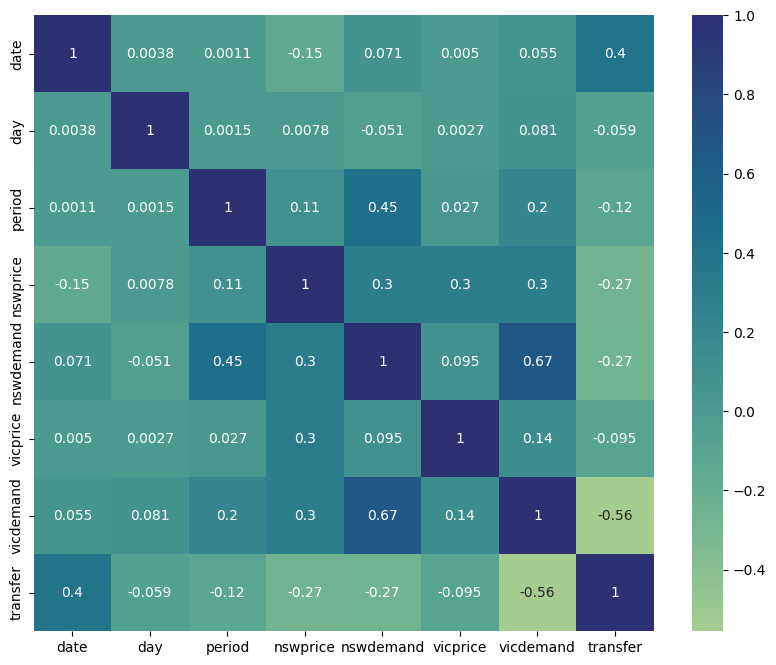

In [17]:
# Creating a heatmap to visualize correlations between features
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='crest')

* No features have very high correlation (values between -1 and 1).
* Correlation ≈ 1 → features contain similar information; correlation ≈ -1 → features contain different information.
* Example: `vicdemand` & `nswdemand` correlate at 0.67 → moderate relationship.
* Dropping one of them likely does not affect model performance.
* Low correlation with target does not mean a feature is useless.
* `class` feature missing in matrix → contains categorical values.

### More data exploration

<Axes: xlabel='class', ylabel='count'>

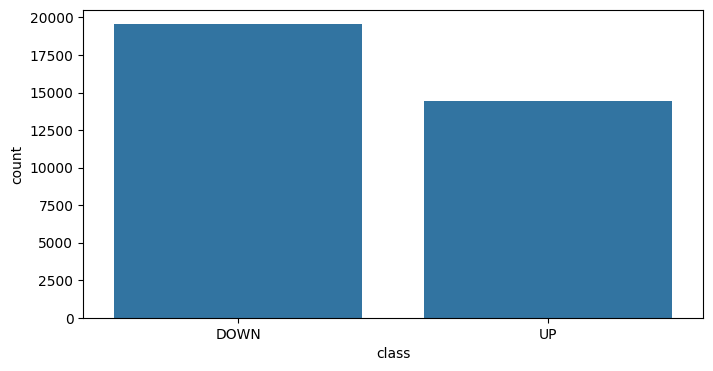

In [18]:
# Plotting the distribution of the target classes in the training data

plt.figure(figsize=(8,4))
sns.countplot(data=train_data, x='class')

`Day` is the days of the week, from (1-7), Monday to Sunday. Now gonna count the days occurences in respect to the ups/downs of the electricity's price.

<Axes: xlabel='day', ylabel='count'>

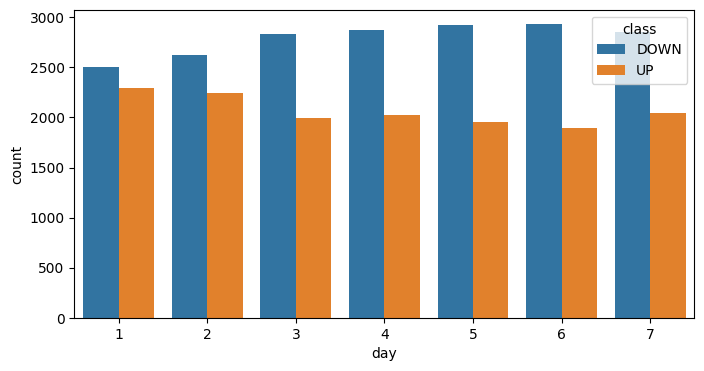

In [19]:
# Plotting the distribution of target classes across different days

plt.figure(figsize=(8,4))
sns.countplot(data=train_data, x='day', hue='class')

Most days show more “DOWN” (price drop) than “UP” (price rise). At the start of the week, downs increase while ups decrease. Next, checking if NSW and Victoria electricity demand/price have a clear relationship.

<Axes: xlabel='vicdemand', ylabel='nswdemand'>

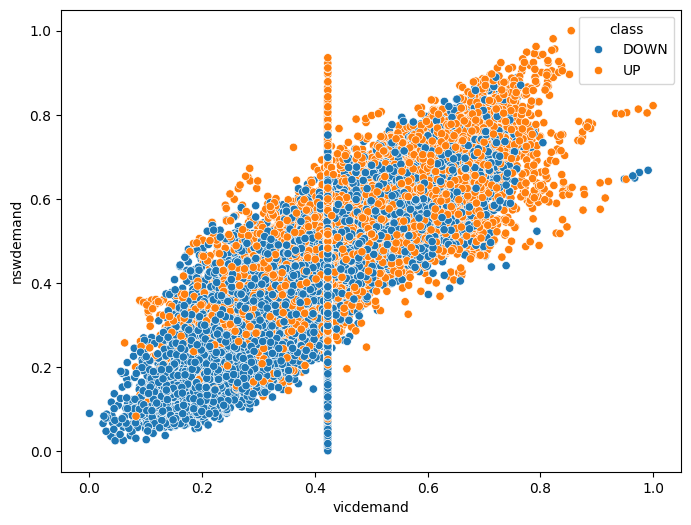

In [20]:
# Creating a scatter plot of Victoria vs NSW demand, colored by class

plt.figure(figsize=(8,6))
sns.scatterplot(data=train_data, x='vicdemand', y='nswdemand', hue='class')

The demand of the electricity in New South Wales and the Victoria is kind of linear. Let's see if I can get any other insights by bringing days in the demand analysis.

<Axes: xlabel='vicdemand', ylabel='nswdemand'>

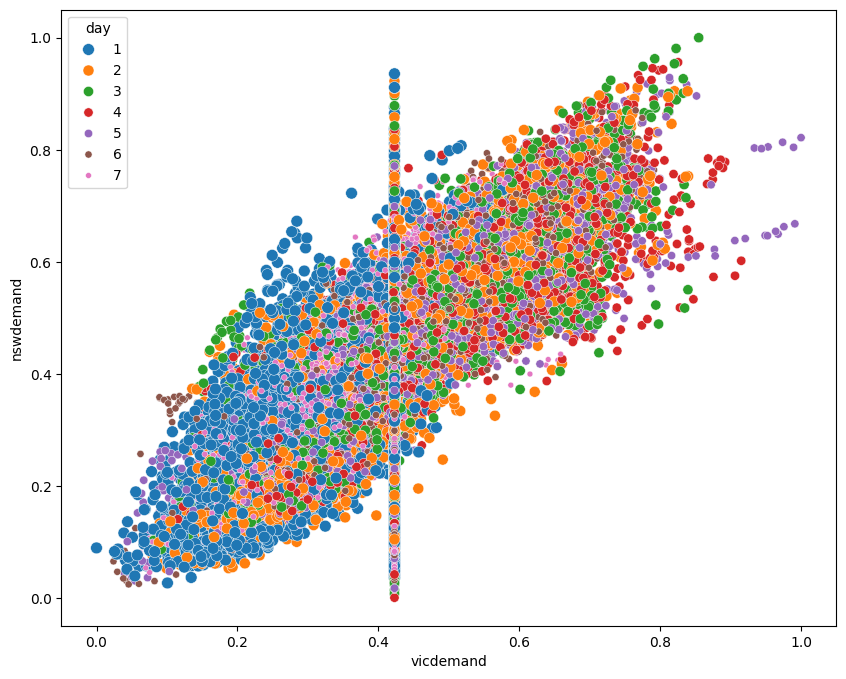

In [21]:
# Creating a scatter plot of Victoria vs NSW demand,
# with points colored and sized based on the day of the week
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train_data, x='vicdemand', y='nswdemand', hue='day', size='day')

Although it is kind of hard to draw a strong point, there is less demand of electricity in both cities on Monday and Sunday than other days. I can use a line plot to plot the demand in both cities on the course of the days.

<Axes: xlabel='day', ylabel='nswdemand'>

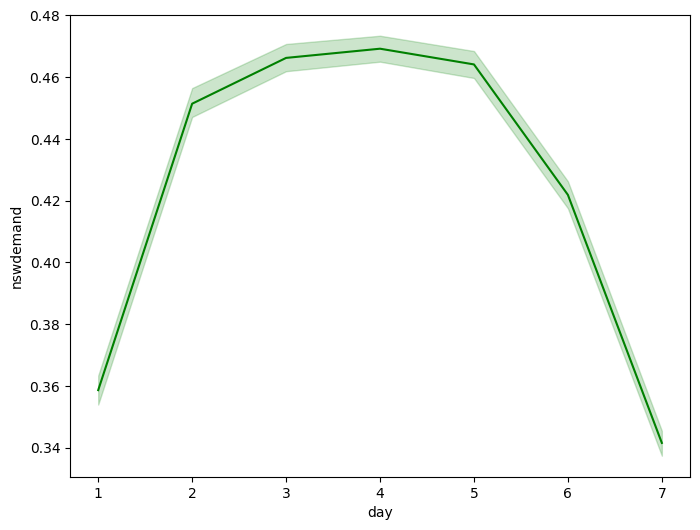

In [22]:
# Creating a line plot showing NSW demand across different days

plt.figure(figsize=(8,6))
sns.lineplot(data=train_data, x='day', y='nswdemand', color='green')

<Axes: xlabel='day', ylabel='vicdemand'>

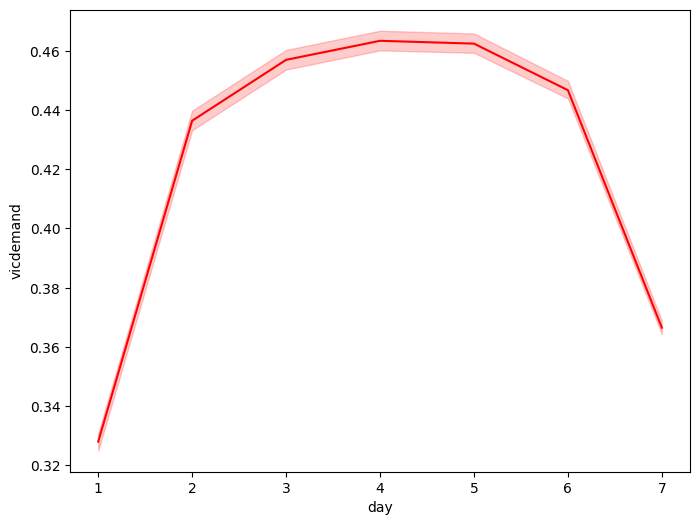

In [23]:
# Creating a line plot showing Victoria demand across different days

plt.figure(figsize=(8, 6))
sns.lineplot(data=train_data, x='day', y='vicdemand', color='red')

* **Seasonality**: Repeating patterns over time (e.g., weekend shopping spikes).
* **Trend**: Long-term increase/decrease (e.g., Moore’s Law).
* Real data can have **seasonality + trend + noise**.
* Electricity demand in NSW and Victoria shows possible seasonal patterns over time.

<Axes: xlabel='date', ylabel='nswdemand'>

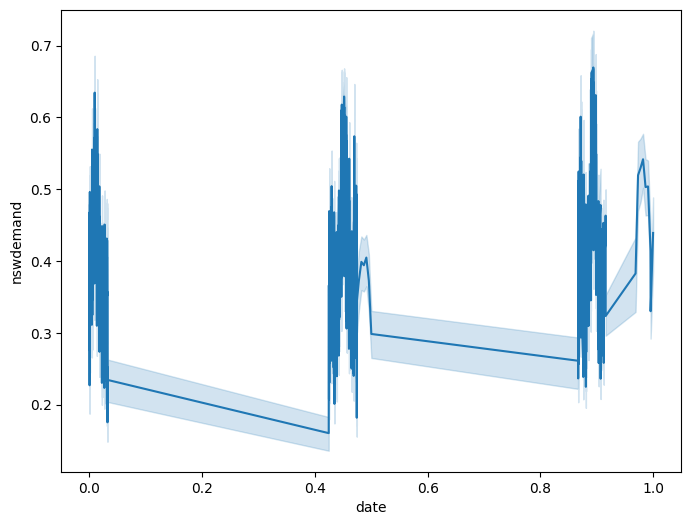

In [24]:
# Creating a line plot showing NSW demand over time (by date)

plt.figure(figsize=(8,6))
sns.lineplot(data=train_data, x='date', y='nswdemand')

<Axes: xlabel='date', ylabel='vicdemand'>

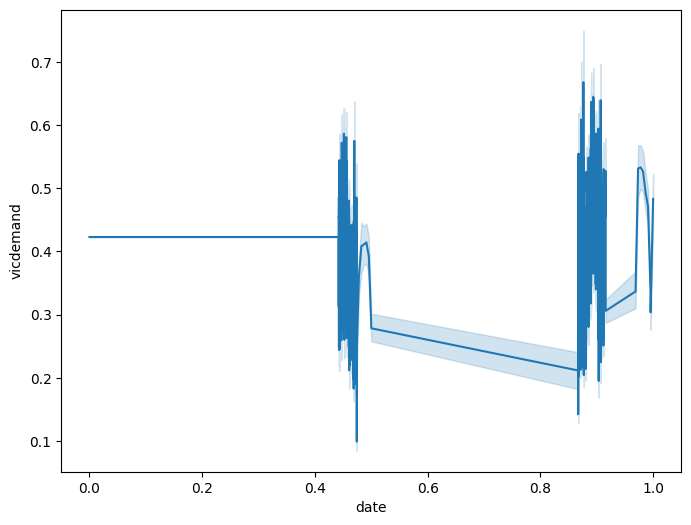

In [25]:
# Creating a line plot showing Victoria demand over time (by date)

plt.figure(figsize=(8,6))
sns.lineplot(data=train_data, x='date', y='vicdemand')

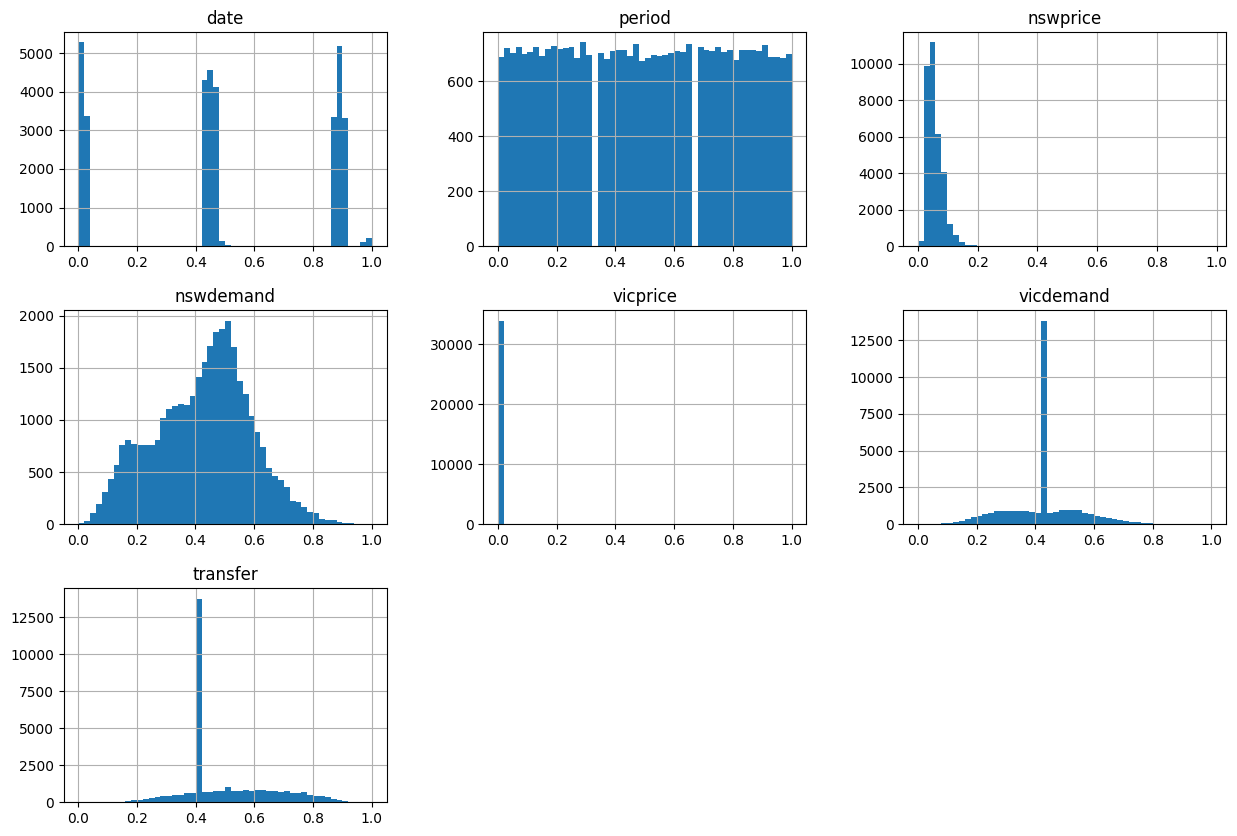

In [26]:
# Plotting histograms for all features in the training data to check distributions

train_data.hist(bins=50, figsize=(15,10))
plt.show()

<a name='4'></a>

## 4 - Data Preprocessing

In [27]:
# Encoding target labels into numbers for model training

from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y_train_prepared = label_enc.fit_transform(y_train)

<a name='5'></a>

## 5 - Training Random Forests Classifier

In [28]:
# Importing Random Forest classifier, creating an instance, and training it on the training data

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()

forest_clf.fit(X_train, y_train_prepared)

RandomForestClassifier()

<a name='6'></a>

## 6 - Evaluating Random Forests Classifier

Building 3 functions for model evaluation:

* **Accuracy** → shows how often the model predicts correctly.
* **Confusion Matrix** → shows actual vs predicted classes (TN, TP, FN, FP).
* **Classification Report** → shows precision, recall, and F1 score together.

In [29]:
from sklearn.metrics import accuracy_score

def accuracy(input_data,model,labels):

    preds = model.predict(input_data)
    acc = accuracy_score(labels,preds)

    return acc

In [51]:
from sklearn.metrics import confusion_matrix

def conf_matrix(input_data,model,labels):

    preds = model.predict(input_data)
    cm = confusion_matrix(labels,preds)

    return cm

In [31]:
from sklearn.metrics import classification_report

def class_report(input_data,model,labels):

    preds = model.predict(input_data)
    report = classification_report(labels,preds)
    report = print(report)

    return report

In [32]:
accuracy(X_train, forest_clf, y_train_prepared)

1.0

Oh, the model is overfitting — performing well on training data but not generalizing.
Next, showing the **classification report** and **confusion matrix** to understand performance better.


In [33]:
conf_matrix(X_train, forest_clf, y_train_prepared)

array([[19541,     0],
       [    0, 14443]])

In [34]:
class_report(X_train, forest_clf, y_train_prepared)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19541
           1       1.00      1.00      1.00     14443

    accuracy                           1.00     33984
   macro avg       1.00      1.00      1.00     33984
weighted avg       1.00      1.00      1.00     33984



<a name='7'></a>

## 7 - Improving Random Forests

### 🧩 Cell 1 – Checking current parameters

In [35]:
# Checking current random forest model parameters
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### ⚙️ Cell 2 – Setting up Grid Search

In [36]:
# Importing GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Defining hyperparameter grid for Random Forest
params_grid = {
    'n_estimators': [100, 200, 300, 500],     # number of trees
    'max_leaf_nodes': list(range(0, 10)),     # controlling complexity
    'min_samples_leaf': [0, 1, 2, 3, 4]       # minimum samples in leaf
}

# Creating GridSearchCV to find best parameters
grid_search = GridSearchCV(
    RandomForestClassifier(
        bootstrap=False,                      # disabling sampling
        class_weight='balanced',              # handling imbalance
        n_jobs=-1,                            # using all cores
        max_features='sqrt'                   # selecting random features
    ),
    params_grid,
    verbose=1,
    cv=3                                      # 3-fold cross validation
)

# Fitting the model on training data
grid_search.fit(X_train, y_train_prepared)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1),
             param_grid={'max_leaf_nodes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [0, 1, 2, 3, 4],
                         'n_estimators': [100, 200, 300, 500]},
             verbose=1)

### 🏆 Cell 3 – Checking best parameters

In [37]:
# Checking which parameters worked best
grid_search.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 4, 'n_estimators': 200}

In [38]:
# Checking best estimator (model)
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_leaf_nodes=9, min_samples_leaf=4, n_estimators=200,
                       n_jobs=-1)

### 🌳 Cell 4 – Creating best model

In [39]:
# Assigning the best model found by Grid Search
forest_best = grid_search.best_estimator_

### 📈 Cell 5 – Checking accuracy

In [40]:
# Checking model accuracy on training data
from sklearn.metrics import accuracy_score

accuracy_score(y_train_prepared, forest_best.predict(X_train))

0.7934027777777778

### 🔍 Cell 6 – Confusion Matrix

In [50]:
# Checking confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_prepared, forest_best.predict(X_train))

array([[17076,  2465],
       [ 4556,  9887]])

### 🧾 Cell 7 – Classification Report

In [42]:
# Showing precision, recall, and F1-score
from sklearn.metrics import classification_report

print(classification_report(y_train_prepared, forest_best.predict(X_train)))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     19541
           1       0.80      0.68      0.74     14443

    accuracy                           0.79     33984
   macro avg       0.79      0.78      0.78     33984
weighted avg       0.79      0.79      0.79     33984



### 💡 Cell 8 – Short summary notes

In [43]:
# Model improved slightly after tuning
# Accuracy ≈ 79%
# Model handling imbalance better due to 'class_weight = balanced'

# Precision → correctly predicting positive examples
# Recall → how many real positives were found
# F1 score → balance between precision and recall

# Still overfitting slightly — can try more tuning or add more quality data.

<a name='8'></a>
## 8. Evaluating the Model on the Test Set

I'm gonna evaluate the model on the test set. But I will first run the label_encoder on the class feature as I did in the training labels. Note that I only transform (not fit_transform).

In [44]:
X_test = test_data.drop('class', axis=1)
y_test = test_data['class']

y_test_prepared = label_enc.transform(y_test)

In [45]:
accuracy(X_test, forest_best, y_test_prepared)

0.7901659604519774

In [52]:
conf_matrix(X_test, forest_best, y_test_prepared)

array([[5673,  861],
       [1516, 3278]])

In [47]:
class_report(X_test, forest_best, y_test_prepared)

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      6534
           1       0.79      0.68      0.73      4794

    accuracy                           0.79     11328
   macro avg       0.79      0.78      0.78     11328
weighted avg       0.79      0.79      0.79     11328



The model is no longer overfitting. On the training set, the accuracy was 79% and so on the test set. And the model never saw the test data. To improve the model in the case like this, if is often best to add more data if possible.

<a name='9'></a>
## 9. Feature Importance

Different to other machine learning models, random forests can show how each feature contributed to the model generalization.

The results are values between 0 and 1. The closer to 1, the good the feature was to the model.

In [48]:
feat_import = forest_best.feature_importances_

feat_df = pd.DataFrame(feat_import, columns=['Feature Importance'], index=X_train.columns)
feat_df

,Feature Importance
date,0.058556
day,0.014016
period,0.084723
nswprice,0.470143
nswdemand,0.184766
vicprice,0.148221
vicdemand,0.030838
transfer,0.008736
